In [1]:
# -*- coding: utf-8 -*-
"""
Created on May 27, 2024
Last modified on May 27, 2024
@Author: Guan-Fu Liu

To test the ChemEvo.py
"""
from ChemEvo import *
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib widget

In [2]:
SFH = { }
SFH['File'] = f"./inputs/SFH.h5"
with h5py.File(SFH['File'], 'r') as f:
    SFH['Age'] = f['SFH/1Square'][...][:, 0]
    SFH['SFR'] = f['SFH/1Square'][...][:, 1]

SFE = 0.3
###### For comparison with galIMF ######
# yield_files = {"AGB+SNcc": "./inputs/NuPyCEE/portinari98_gce_in_igimf/yields1.h5",
#                 "SNIa": "./inputs/SNIa_TNH93/yields1.h5"}
# mass_lifetime_file = "./inputs/NuPyCEE/isotope_yield_table_portinari98_marigo01_gce_totalyields/yields1.h5"
# p_denominator=4.819420e-04
# p_numerator=1.575560e-04
# p_preset = p_numerator/p_denominator  #  The calibration factor of SNIa rate from galIMF
# out_file = "ChemEvo_galIMF_set.h5"
# comments = "To compare the result with that of galIMF"
###### For comparison with galIMF ######

###### For comparison with Nomoto et al. (2013) ######
yield_files = {
                "AGB+SNcc": "./inputs/NuPyCEE/agb_and_massive_stars_C15_N13_0_5_HNe/yields2.h5",
                "SNIa": "./inputs/NuPyCEE/sn1a_i99_W7/yields2.h5",
               }
mass_lifetime_file = "./inputs/NuPyCEE/agb_and_massive_stars_C15_N13_0_5_HNe/yields2.h5"
p_preset = None
out_file = "ChemEvo_N13.h5"
comments = "To compare the result with that of Nomoto et al. (2013)"
###### For comparison with Nomoto et al. (2013) ######

imf_dict = {"Salpeter": None}
ElemNotice = ["H", "He", "C", "N", "O", "Ne", "Si", "Mg", "S", "Ca", "Fe", "Other"]
interp_kind = "linear-linear"
SNIaOn = True
solar_set = "Default"
Z_0 = 0
output_dir = "./outputs"
def imf_evolve(Z_gas):
    if Z_gas < 0.02:
        return lambda m: m**(-1.3) if (m>=constants.Mstar_min and m<=constants.Mstar_max) else 0
    else:
        return lambda m: m**(-2.35) if (m>=constants.Mstar_min and m<=constants.Mstar_max) else 0

GasElement, ZGas, EjectElement, SNIaElement, SNccElement, AGB_Element, StarInitElement, YieldsTable,\
           SNIaNum, SNccNum, AGB_Num, Nstar, StellarMass = \
            ChemEvo(SFH, SFE, yield_files, imf_dict=imf_dict, imf_evolve=None, SNIaOn=SNIaOn, p_preset=p_preset,
                    mass_lifetime_file=mass_lifetime_file,
                    interp_kind=interp_kind, solar_set=solar_set, Z_0=Z_0, input_primodiral_gas=None,
                    ElemNotice=ElemNotice, 
                    output_dir=output_dir, out_file=out_file, comments=comments)

The elements you notice but not available in the yield table of SNIa, Z_0_02 are
 {'H', 'He'}
Step 0: Initialize the first age, the primordial gas


100%|██████████| 1363/1363 [00:08<00:00, 165.43it/s]


Step 1: Calculate the remaining ages


100%|██████████| 1362/1362 [25:13<00:00,  1.11s/it]


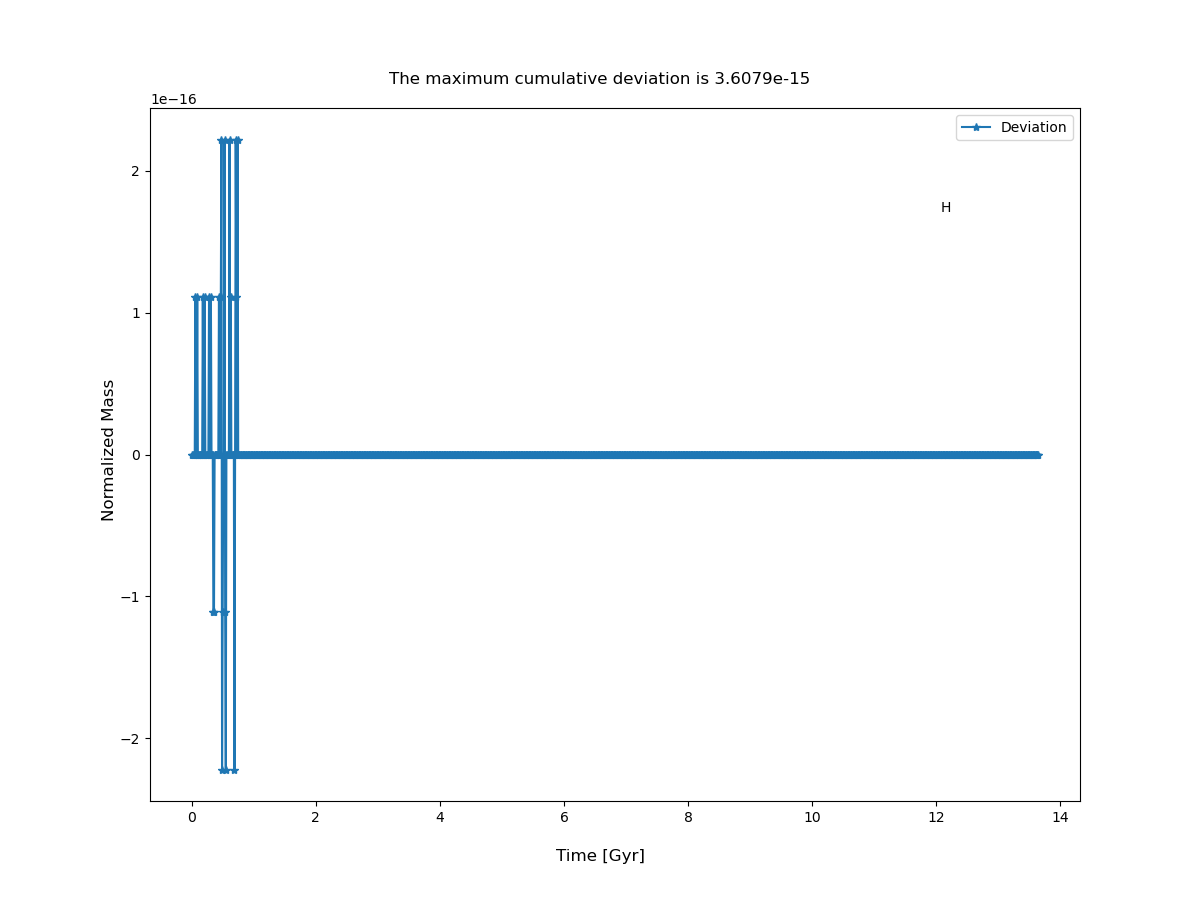

8.940696716308594e-08


In [14]:
fig = plt.figure(figsize=(12,9))
gs = GridSpec(1, 1, width_ratios=[1], height_ratios=[1], wspace=0.0, hspace=0.0)
axes = { }
ElemNotice = ["H"]
for i, elem in enumerate(ElemNotice):
    axes[elem] = fig.add_subplot(gs[i//3, i%3])
    norm = EjectElement[:, constants.elem_names.index(elem)].max()
    axes[elem].plot(SFH['Age']/1e9, (SNccElement[:, constants.elem_names.index(elem)]+
                                     AGB_Element[:, constants.elem_names.index(elem)]+
                                     SNIaElement[:, constants.elem_names.index(elem)])/norm-
                                     EjectElement[:, constants.elem_names.index(elem)]/norm, 
                                     '-*',
                                     label="Deviation")
    axes[elem].annotate(elem, xy=(0.85, 0.85), xycoords='axes fraction')
    axes[elem].legend(loc='upper right')

fig.supxlabel("Time [Gyr]", y=0.04)
fig.supylabel(r"Normalized Mass", x=0.085)
deviation = np.abs(EjectElement.cumsum(axis=0)-SNccElement.cumsum(axis=0)-AGB_Element.cumsum(axis=0)-SNIaElement.cumsum(axis=0))
mask = EjectElement>0
deviation = deviation[mask]
deviation = deviation / EjectElement.cumsum(axis=0)[mask]
deviation = deviation.max()
fig.suptitle("The maximum cumulative deviation is %0.4e" % deviation, y=0.92)
plt.show()
print(np.abs(EjectElement-SNccElement-AGB_Element-SNIaElement).max())